<a target="_blank" href="https://colab.research.google.com/github/emiletimothy/Caltech-CS155-2023/blob/main/set6/HMM.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS155 Set 6

**Imports**

In [ ]:
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import random

## HMM CODE (TODO)

In [ ]:
# You can use this skeleton code to complete the HMM
# implementation of set 5. Once each part is implemented, you can simply
# execute the related problem scripts (e.g. run 'python 2G.py') to quickly
# see the results from your code.
#
# Some pointers to get you started:
#
#     - Choose your notation carefully and consistently! Readable
#       notation will make all the difference in the time it takes you
#       to implement this class, as well as how difficult it is to debug.
#
#     - Read the documentation in this file! Make sure you know what
#       is expected from each function and what each variable is.
#
#     - Any reference to "the (i, j)^th" element of a matrix T means that
#       you should use T[i][j].
#
#     - Note that in our solution code, no NumPy was used. That is, there
#       are no fancy tricks here, just basic coding. If you understand HMMs
#       to a thorough extent, the rest of this implementation should come
#       naturally. However, if you'd like to use NumPy, feel free to.
#
#     - Take one step at a time! Move onto the next algorithm to implement
#       only if you're absolutely sure that all previous algorithms are
#       correct. We are providing you waypoints for this reason.
#
# To get started, just fill in code where indicated. Best of luck!

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        for state in range(self.L):
          probs[1][state] = self.A_start[state] * self.O[state][x[0]]
          seqs[1][state] = str(state)
        max_seq=""
        for seq_len in range(2, M+1):
          for curr_state in range(self.L):
            max_p = 0
            
            for prev_state in range(self.L):
              p = probs[seq_len-1][prev_state] * self.A[prev_state][curr_state] * self.O[curr_state][x[seq_len-1]]
              if p > max_p:
                max_p = p
                max_seq = seqs[seq_len-1][prev_state]

            seqs[seq_len][curr_state]=  max_seq + str(curr_state)
            probs[seq_len][curr_state] = max_p

        max_seq = seqs[-1][0]
        max_prob = probs[-1][0]
        for state in range(1, self.L):
            if probs[-1][state] > max_prob:
                max_prob = probs[-1][state]
                max_seq = seqs[-1][state]
        return max_seq
        # max_seq = seqs
        # return max_seq[-1][-1] #max seq should be a vector


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]
 
        for state in range(self.L):
          alphas[1][state] = self.A_start[state] * self.O[state][x[0]]

        for time in range(2, M+1):
          for state in range(self.L):
            for prev_state in range(self.L):
              alphas[time][state] += self.A[prev_state][state] * self.O[state][x[time-1]] * alphas[time-1][prev_state]
          

        if (normalize == True):
          for i in range(len(alphas)):
            alphas_sum = sum(alphas[i])
            if (alphas_sum != 0):
              alphas[i] = np.divide(alphas[i], alphas_sum)

        return alphas



    def backward(self, x, normalize=False): #this isn't working yet
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]


        for state in range(self.L):
          betas[M][state] = 1
        
        for time in range(M-1, -1, -1):
          for curr_state in range(self.L):
              for next_state in range(self.L):
                if (time != 0):
                  betas[time][curr_state] += self.A[curr_state][next_state] * self.O[next_state][x[time]] * betas[time+1][next_state]
                else:
                  betas[time][curr_state] += self.A_start[next_state] * self.O[next_state][x[time]] * betas[time+1][next_state]
        if (normalize == True):
          for i in range(len(betas)):
            betas_sum = sum(betas[i])
            if (betas_sum != 0):
              betas[i] = np.divide(betas[i], betas_sum)



        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.

        transitions = np.zeros((self.L, self.L))
        states = np.zeros(self.L)

        for n in range(len(Y)):
          s = Y[n]
          for i in range(len(s)-1):
            transitions[s[i+1]][s[i]]+=1
            states[s[i]] +=1
        
        self.A = np.array(transitions/states).T

        # Calculate each element of O using the M-step formulas.

        obs_mat = np.zeros((self.D, self.L))
        obs_states = np.zeros(self.L)

        for n in range(len(Y)):
          o = X[n]
          s1 = Y[n]
          for i in range(len(o)):
            obs_mat[o[i]][s1[i]] +=1
            obs_states[s1[i]] +=1
        
        self.O = np.array(obs_mat/obs_states).T
           

    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''
        # Attemp: 3 ;)
        trans_top = np.zeros((self.L, self.L))
        trans_bottom = np.zeros((self.L, self.L))
        emit_top = np.zeros((self.L, self.D))
        emit_bottom = np.zeros((self.L, self.D))

        for i in range(N_iters):
          trans_top.fill(0.0)
          trans_bottom.fill(0.0)
          emit_top.fill(0.0)
          emit_bottom.fill(0.0)
          for x in X:
            M = len(x)
            alphas = self.forward(x, True)
            betas = self.backward(x, True)

            for t in range(1, M + 1):
              p = np.array([alphas[t][curr_state] * betas[t][curr_state] for curr_state in range(self.L)])
              p /= (np.sum(p) if (np.sum(p) != 0) else 1.0)
              if (t < M):
                p2 = [[alphas[t][curr_state] * self.O[next_state][x[t]] * self.A[curr_state][next_state] * betas[t+1][next_state] for next_state in range(self.L)] for curr_state in range(self.L)]
                p2 /= (np.sum(p2) if np.sum(p2 != 0) else 1.0)

              for curr_state in range(self.L):
                emit_top[curr_state][x[t-1]] += p[curr_state]
                emit_bottom[curr_state] += p[curr_state]
                if t < M:
                  trans_bottom[curr_state] += p[curr_state]
                  for next_state in range(self.L):
                    trans_top[curr_state][next_state] += p2[curr_state][next_state]

          self.A = np.divide(trans_top, trans_bottom)
          self.O = np.divide(emit_top, emit_bottom)
        # Attemp: 2 ;(
        # Initialize A and O matrices randomly -> done in unsupervised_HHM

        # for i in range(N_iters):
        #   #Marginals
        #   #Expectation: compute the expected sufficient statistics.
        #   expected_trans_counts = [[0. for _ in range(self.L)] for _ in range(self.L)]
        #   expected_emit_counts = [[0. for _ in range(self.D)] for _ in range(self.L)]

        #   for x in X:
        #       alpha = self.forward(x, True)
        #       beta = self.backward(x, True)
              
        #       #Cause of error I am pretty sure is when normalizing so instead of normalzing 
        #       #I am trying to normalzie here
        #       # Compute the total probability of the sequence.


        #       # Update expected_trans_counts and expected_emit_counts lec14 slide 20.
        #       for time in range(1, len(x)):
        #         for curr_state in range(self.L):
        #           for prev_state in range(self.L):
        #             expected_trans_counts[prev_state][curr_state] += alpha[time][prev_state] * self.A[prev_state][curr_state] * self.O[curr_state][x[time]] * beta[time+1][curr_state]
        #           expected_emit_counts[curr_state][x[time]] += alpha[time+1][curr_state] * beta[time+1][curr_state]
        
        #   # Maximazation: lec14 slide 24
        #   # Update A.
        #   for i in range(self.L):
        #     row_sum = sum(expected_trans_counts[i])
        #     for j in range(self.L):
        #         self.A[i][j] = expected_trans_counts[i][j] / row_sum

        #   # Update O.
        #   for i in range(self.L):
        #     row_sum = sum(expected_emit_counts[i])
        #     for j in range(self.D):
        #         self.O[i][j] = (expected_emit_counts[i][j] / row_sum)
        # Attemp: 1 ;/
        # #Randomly initialize (A, O)
        # M = len(X)
        # A_new = self.A
        # O_new = self.O

        # for n in range(N_iters):
        #   fwd = [self.forward(seq) for seq in X]
        #   bck = [self.backward(seq) for seq in X]
        #   gammas = []
        #   eps = []
        #   for time in range(1, M+1):
        #     # Initialize matrices for storing intermediate values for marginals
        #     # eps holds the initial estimate of the probability of transitioning from hidden state i to hidden state j at time step m.
        #     # gammas represents the initial estimate of the probability of being in hidden state i at time step m.
        #     # eps = [[[0. for i in range(self.L)] for j in range(self.L)] for k in range(M)]
        #     # gammas = [[0. for i in range(self.L)] for j in range(M)]

        #     alphas = fwd[time -1]
        #     betas = bck[time - 1]
        #     x = X[time-1]
        #     T = len(alphas)
        #     g = np.zeros((T, self.L))
        #     for i in range(self.L):
        #       numerator = alphas[time][i] * betas[time][i]
        #       gammas[time-1][i] = numerator
        #       if time < M:
        #         for j in range(self.L):
        #           denominator = alphas[time][i] * self.A[i][j] * self.O[j][x[time]] * betas[time+1][j]
        #           eps[time-1][i][j] = denominator

        #     # Normalize gamma values.
        #     gamma_sum = sum(gammas[time-1])
        #     if gamma_sum != 0:
        #         gammas[time-1] = [gamma / gamma_sum for gamma in gammas[time-1]]
        #     print(eps, 'hold up\n', gammas)
        #     # Maximizing step
        #     for i in range(self.L):
        #       # Update transition matrix.
        #       for j in range(self.L):
        #         eps_sum = sum([eps[time-1][i][j] for time in range(1, M)])
        #         gamma_sum = sum([gammas[time-1][i] for time in range(1, M)])
        #         if gamma_sum != 0:
        #           A_new[i][j] = eps_sum / gamma_sum
              
        #       # Update emission matrix.
        #       for k in range(self.D):
        #         gamma_xk_sum = sum([gammas[time-1][i] for time in range(1, M) if x[time-1] == k])
        #         gamma_sum = sum([gammas[time-1][i] for time in range(1, M)])
        #         if gamma_sum != 0:
        #             O_new[i][k] = gamma_xk_sum / gamma_sum
          
        #   self.A = A_new
        #   self.O = O_new




#work
    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''
        
        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []
        
        new_state = np.random.choice(self.L)
        for idx in range(M):
            states.append(new_state)
            state = int(states[idx])
            e = np.random.choice(self.D, size=1, p=self.O[state])
            emission.append(e[0])
            new_state = np.random.choice(self.L, size=1, p=self.A[state])

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

**HMM helper code. No need to modify anything here.** 

In [ ]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


**Additional helper code. No need to modify anything here**

In [ ]:
class Utility:
    '''
    Utility for the problem files.
    '''

    def __init__():
        pass

    @staticmethod
    def load_sequence(n):
        '''
        Load the file 'sequence_data<n>.txt' for a given n.
        Arguments:
            n:          Sequence index.
        Returns:
            A:          The transition matrix.
            O:          The observation matrix.
            seqs:       Input sequences.
        '''
        A = []
        O = []
        seqs = []

        # For each file:
        with urllib.request.urlopen(f'https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set6/data/sequence_data{n}.txt') as f:
            # Read the parameters.
            L, D = [int(x) for x in f.readline().decode('utf-8').strip().split('\t')]

            # Read the transition matrix.
            for i in range(L):
                A.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # Read the observation matrix.
            for i in range(L):
                O.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # The rest of the file consists of sequences.
            while True:
                seq = f.readline().decode('utf-8').strip()
                if seq == '':
                    break
                seqs.append([int(x) for x in seq])

        return A, O, seqs

    @staticmethod
    def load_ron():
        '''
        Loads the file 'ron.txt'.
        Returns:
            moods:      Sequnces of states, i.e. a list of lists.
                        Each sequence represents half a year of data.
            mood_map:   A hash map that maps each state to an integer.
            genres:     Sequences of observations, i.e. a list of lists.
                        Each sequence represents half a year of data.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods = []
        mood_map = {}
        genres = []
        genre_map = {}
        mood_counter = 0
        genre_counter = 0

        with urllib.request.urlopen("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set6/data/ron.txt") as f:
            mood_seq = []
            genre_seq = []

            while True:
                line = f.readline().decode('utf-8').strip()

                if line == '' or line == '-':
                    # A half year has passed. Add the current sequence to
                    # the list of sequences.
                    moods.append(mood_seq)
                    genres.append(genre_seq)
                    # Start new sequences.
                    mood_seq = []
                    genre_seq = []
                
                if line == '':
                    break
                elif line == '-':
                    continue
                
                mood, genre = line.split()
                
                # Add new moods to the mood state hash map.
                if mood not in mood_map:
                    mood_map[mood] = mood_counter
                    mood_counter += 1

                mood_seq.append(mood_map[mood])

                # Add new genres to the genre observation hash map.
                if genre not in genre_map:
                    genre_map[genre] = genre_counter
                    genre_counter += 1

                # Convert the genre into an integer.
                genre_seq.append(genre_map[genre])

        return moods, mood_map, genres, genre_map

    @staticmethod
    def load_ron_hidden():
        '''
        Loads the file 'ron.txt' and hides the states.
        Returns:
            genres:     The observations.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods, mood_map, genres, genre_map = Utility.load_ron()

        return genres, genre_map

# Problem 2

## Part A <br>
**No need to modify anything here. This should work if your HMM code is correct**

In [ ]:
#part A
def sequence_prediction(n):
    '''
    Runs sequence prediction on the five sequences at the end of the file
    'sequence_data<n>.txt' for a given n and prints the results.
    Arguments:
        n:          Sequence index.
    '''
    A, O, seqs = Utility.load_sequence(n)

    # Print file information.
    print("File #{}:".format(n))
    print("{:30}{:30}".format('Emission Sequence', 'Max Probability State Sequence'))
    print('#' * 70)

    # For each input sequence:
    for seq in seqs:
        # Initialize an HMM.
        HMM = HiddenMarkovModel(A, O)

        # Make predictions.
        x = ''.join([str(xi) for xi in seq])
        y = HMM.viterbi(seq)
        
        # Print the results.
        print("{:30}{:30}".format(x, y))
        
    print('')

for n in range(6):
    sequence_prediction(n)

File #0:
Emission Sequence             Max Probability State Sequence
######################################################################
25421                         31033                         
01232367534                   22222100310                   
5452674261527433              1031003103222222              
7226213164512267255           1310331000033100310           
0247120602352051010255241     2222222222222222222222103     

File #1:
Emission Sequence             Max Probability State Sequence
######################################################################
77550                         22222                         
7224523677                    2222221000                    
505767442426747               222100003310031               
72134131645536112267          10310310000310333100          
4733667771450051060253041     2221000003222223103222223     

File #2:
Emission Sequence             Max Probability State Sequence
####################################

## Part Bi <br>
**No need to modify anything here. This should work if your HMM code is correct**

In [ ]:
def sequence_probability(n):
    '''
    Determines the probability of emitting the five sequences at the end of
    the file 'sequence_data<n>.txt' for a given n and prints the results.
    Arguments:
        n:          File index.
    '''
    A, O, seqs = Utility.load_sequence(n)

    # Print file information.
    print("File #{}:".format(n))
    print("{:30}{:10}".format('Emission Sequence', 'Probability of Emitting Sequence'))
    print('#' * 70)

    # For each input sequence:
    for seq in seqs:
        # Initialize an HMM.
        HMM = HiddenMarkovModel(A, O)

        # Compute the probability of the input sequence.
        x = ''.join([str(xi) for xi in seq])
        p = HMM.probability_alphas(seq)
        
        # Print the results.
        print("{:30}{:<10.3e}".format(x, p))

    print('')

for n in range(6):
    sequence_probability(n)

File #0:
Emission Sequence             Probability of Emitting Sequence
######################################################################
25421                         4.537e-05 
01232367534                   1.620e-11 
5452674261527433              4.348e-15 
7226213164512267255           4.739e-18 
0247120602352051010255241     9.365e-24 

File #1:
Emission Sequence             Probability of Emitting Sequence
######################################################################
77550                         1.181e-04 
7224523677                    2.033e-09 
505767442426747               2.477e-13 
72134131645536112267          8.871e-20 
4733667771450051060253041     3.740e-24 

File #2:
Emission Sequence             Probability of Emitting Sequence
######################################################################
60622                         2.088e-05 
4687981156                    5.181e-11 
815833657775062               3.315e-15 
21310222515963505015          5.126e

## Part Bii <br>
**No need to modify anything here. This should work if your HMM code is correct**

In [ ]:
def sequence_probability(n):
    '''
    Determines the probability of emitting the five sequences at the end of
    the file 'sequence_data<n>.txt' for a given n and prints the results.
    Arguments:
        n:          File index.
    '''
    A, O, seqs = Utility.load_sequence(n)

    # Print file information.
    print("File #{}:".format(n))
    print("{:30}{:10}".format('Emission Sequence', 'Probability of Emitting Sequence'))
    print('#' * 70)

    # For each input sequence:
    for seq in seqs:
        # Initialize an HMM.
        HMM = HiddenMarkovModel(A, O)

        # Compute the probability of the input sequence.
        x = ''.join([str(xi) for xi in seq])
        p = HMM.probability_betas(seq)
        
        # Print the results.
        print("{:30}{:<10.3e}".format(x, p))

    print('')

for n in range(6):
    sequence_probability(n)

File #0:
Emission Sequence             Probability of Emitting Sequence
######################################################################
25421                         4.537e-05 
01232367534                   1.620e-11 
5452674261527433              4.348e-15 
7226213164512267255           4.739e-18 
0247120602352051010255241     9.365e-24 

File #1:
Emission Sequence             Probability of Emitting Sequence
######################################################################
77550                         1.181e-04 
7224523677                    2.033e-09 
505767442426747               2.477e-13 
72134131645536112267          8.871e-20 
4733667771450051060253041     3.740e-24 

File #2:
Emission Sequence             Probability of Emitting Sequence
######################################################################
60622                         2.088e-05 
4687981156                    5.181e-11 
815833657775062               3.315e-15 
21310222515963505015          5.126e

## Part C <br>
**No need to modify anything here. This should work if your HMM code is correct**

In [ ]:
def supervised_learning():
    '''
    Trains an HMM using supervised learning on the file 'ron.txt' and
    prints the results.
    '''
    moods, mood_map, genres, genre_map = Utility.load_ron()

    # Train the HMM.
    HMM = supervised_HMM(genres, moods)

    # Print the transition matrix.
    print("Transition Matrix:")
    print('#' * 70)
    for i in range(len(HMM.A)):
        print(''.join("{:<12.3e}".format(HMM.A[i][j]) for j in range(len(HMM.A[i]))))
    print('')
    print('')

    # Print the observation matrix. 
    print("Observation Matrix:  ")
    print('#' * 70)
    for i in range(len(HMM.O)):
        print(''.join("{:<12.3e}".format(HMM.O[i][j]) for j in range(len(HMM.O[i]))))
    print('')

supervised_learning()

Transition Matrix:
######################################################################
2.833e-01   4.714e-01   1.310e-01   1.143e-01   
2.321e-01   3.810e-01   2.940e-01   9.284e-02   
1.040e-01   9.760e-02   3.696e-01   4.288e-01   
1.883e-01   9.903e-02   3.052e-01   4.075e-01   


Observation Matrix:  
######################################################################
1.486e-01   2.288e-01   1.533e-01   1.179e-01   4.717e-02   5.189e-02   2.830e-02   1.297e-01   9.198e-02   2.358e-03   
1.062e-01   9.653e-03   1.931e-02   3.089e-02   1.699e-01   4.633e-02   1.409e-01   2.394e-01   1.371e-01   1.004e-01   
1.194e-01   4.299e-02   6.529e-02   9.076e-02   1.768e-01   2.022e-01   4.618e-02   5.096e-02   7.803e-02   1.274e-01   
1.694e-01   3.871e-02   1.468e-01   1.823e-01   4.839e-02   6.290e-02   9.032e-02   2.581e-02   2.161e-01   1.935e-02   



## Part D <br>
**No need to modify anything here. This should work if your HMM code is correct**

In [ ]:
def unsupervised_learning(n_states, N_iters, seed=None):
    '''
    Trains an HMM using supervised learning on the file 'ron.txt' and
    prints the results.
    Arguments:
        n_states:   Number of hidden states that the HMM should have.
        N_iters:    Number of EM steps taken.
        rng:        The random number generator used. Default to 1.
    '''
    genres, genre_map = Utility.load_ron_hidden()

    # Train the HMM.
    HMM = unsupervised_HMM(genres, n_states, N_iters, seed=seed)

    # Print the transition matrix.
    print("Transition Matrix:")
    print('#' * 70)
    for i in range(len(HMM.A)):
        print(''.join("{:<12.3e}".format(HMM.A[i][j]) for j in range(len(HMM.A[i]))))
    print('')
    print('')

    # Print the observation matrix. 
    print("Observation Matrix:  ")
    print('#' * 70)
    for i in range(len(HMM.O)):
        print(''.join("{:<12.3e}".format(HMM.O[i][j]) for j in range(len(HMM.O[i]))))
    print('')

unsupervised_learning(4, 1000, seed=1)

Transition Matrix:
######################################################################
4.345e-01   1.559e-01   9.612e-02   3.134e-01   
5.904e-15   2.996e-01   7.004e-01   1.328e-11   
5.219e-01   3.828e-18   2.259e-01   2.522e-01   
5.016e-03   3.679e-01   7.971e-03   6.191e-01   


Observation Matrix:  
######################################################################
2.235e-01   8.353e-09   7.603e-02   9.263e-02   2.315e-02   1.023e-02   1.273e-01   3.294e-01   1.288e-10   1.177e-01   
2.260e-01   3.339e-05   7.427e-14   2.039e-01   3.226e-02   1.151e-01   1.575e-01   3.954e-30   8.256e-02   1.828e-01   
3.403e-02   1.351e-01   1.900e-01   5.006e-02   2.247e-01   2.150e-05   6.462e-02   2.926e-02   2.723e-01   3.988e-65   
8.931e-02   1.173e-01   1.035e-01   9.344e-02   1.505e-01   2.098e-01   9.588e-07   7.679e-02   1.594e-01   1.312e-07   



## Part F <br>
**No need to modify anything here. This should work if your HMM code is correct**

In [ ]:

def sequence_generator(n, k, M, seed=None):
    '''
    Generates k emissions of length M using the HMM stored in the file
    'sequence_data<n>.txt' for a given n and prints the results.
    Arguments:
        N:          File index.
        K:          Number of sequences to generate.
        M:          Length of emission to generate.
    '''
    A, O, seqs = Utility.load_sequence(n)

    # Print file information.
    print("File #{}:".format(n))
    print("{:30}".format('Generated Emission'))
    print('#' * 70)

    # Initialize a random number generator from the seed
    # so that this will generate the same k sequences each call
    rng = np.random.default_rng(seed=seed)

    # Generate k input sequences.
    for i in range(k):
        # Initialize an HMM.
        HMM = HiddenMarkovModel(A, O)

        # Generate a single input sequence of length m.
        emission, states = HMM.generate_emission(M, seed=rng)
        x = ''.join([str(i) for i in emission])

        # Print the results.
        print("{:30}".format(x))

    print('')

for n in range(6):
    sequence_generator(n, 5, 20, seed=1)

File #0:
Generated Emission            
######################################################################
11224100747512043137          
27564524534715307525          
43145737766103775717          
04474505424425551764          
54307105011762744710          

File #1:
Generated Emission            
######################################################################
45740045737310044057          
35474777415241170163          
72552070135071424373          
53641375457750237454          
42001746660735425511          

File #2:
Generated Emission            
######################################################################
99355028976021885930          
29719879914252531117          
35155255031658744953          
28360214703697677634          
98087378159122929239          

File #3:
Generated Emission            
######################################################################
21564142626624004531          
04601150153231121262          
16556440143301620506      

## Visualization of the dataset <br>
**No need to modify anything here. This should work if your HMM code is correct** <br>
We will be using the Constitution as our dataset. First, we visualize the entirety of the Constitution as a wordcloud:



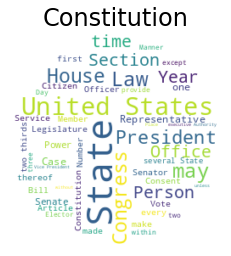

In [ ]:
text = urllib.request.urlopen('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set6/data/constitution.txt').read().decode('utf-8')
wordcloud = text_to_wordcloud(text, title='Constitution')

## Training an HMM <br>
**No need to modify anything here. This should work if your HMM code is correct** <br>
Now we train an HMM on our dataset. We use 10 hidden states and train over 100 iterations:

In [ ]:
obs, obs_map = parse_observations(text)
hmm8 = unsupervised_HMM(obs, 10, 100)

ZeroDivisionError: ignored

## Part G: Visualization of the sparsities of A and O <br>
**No need to modify anything here. This should work if your HMM code is correct** <br>
We can visualize the sparsities of the A and O matrices by treating the matrix entries as intensity values and showing them as images. What patterns do you notice?

In [ ]:
visualize_sparsities(hmm8, O_max_cols=50)

## Generating a sample sentence <br>
As you have already seen, an HMM can be used to generate sample sequences based on the given dataset. Run the cell below to show a sample sentence based on the Constitution.

In [ ]:
print('Sample Sentence:\n====================')
print(sample_sentence(hmm8, obs_map, n_words=25))

## Part H: Using varying numbers of hidden states <br>
**No need to modify anything here. This should work if your HMM code is correct** <br>
Using different numbers of hidden states can lead to different behaviours in the HMMs. Below, we train several HMMs with 1, 2, 4, and 16 hidden states, respectively. What do you notice about their emissions? How do these emissions compare to the emission above

In [ ]:
hmm1 = unsupervised_HMM(obs, 1, 100, seed=1)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm1, obs_map, n_words=25))

In [ ]:

hmm2 = unsupervised_HMM(obs, 2, 100, seed=1)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm2, obs_map, n_words=25))

In [ ]:
hmm4 = unsupervised_HMM(obs, 4, 100, seed=1)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm4, obs_map, n_words=25))

In [ ]:
hmm16 = unsupervised_HMM(obs, 16, 100, seed=1)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm16, obs_map, n_words=25))

## Part I: Visualizing the wordcloud of each state <br>
**No need to modify anything here. This should work if your HMM code is correct** <br>
Below, we visualize each state as a wordcloud by sampling a large emission from the state:

In [ ]:
wordclouds = states_to_wordclouds(hmm8, obs_map)

NameError: ignored

## Visualizing the process of an HMM generating an emission <br>
**No need to modify anything here. This should work if your HMM code is correct** <br>
The visualization below shows how an HMM generates an emission. Each state is shown as a wordcloud on the plot, and transition probabilities between the states are shown as arrows. The darker an arrow, the higher the transition probability.

At every frame, a transition is taken and an observation is emitted from the new state. A red arrow indicates that the transition was just taken. If a transition stays at the same state, it is represented as an arrowhead on top of that state.

Use fullscreen for a better view of the process.

In [ ]:
from IPython.display import HTML
anim = animate_emission(hmm8, obs_map, M=8, seed=1)
HTML(anim.to_html5_video())